# 🧮 Mini optimizer library

In the following example a mini optimizer library is built using `sepes`. The strategy will be to write the optimizer methods with the inplace modification as done in similar libraries like `PyTorch`, then use `value_and_tree` to execute the inplace modification on a new instance and comply with `jax` functional updates.

In [1]:
!pip install git+https://github.com/ASEM000/serket --quiet

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import serket as sk
import functools as ft
import matplotlib.pyplot as plt

## MLP

In [3]:
class MLP(sk.TreeClass):
    def __init__(self, *, key: jax.Array):
        k1, k2 = jr.split(key)
        self.w1 = jax.random.normal(k1, [10, 1])
        self.b1 = jnp.zeros([10], dtype=jnp.float32)
        self.w2 = jax.random.normal(k2, [1, 10])
        self.b2 = jnp.zeros([1], dtype=jnp.float32)

    def __call__(self, input: jax.Array) -> jax.Array:
        output = input @ self.w1.T + self.b1
        output = jax.nn.relu(output)
        output = output @ self.w2.T + self.b2
        return output


def loss_func(net: MLP, input: jax.Array, target: jax.Array) -> jax.Array:
    return jnp.mean((net(input) - target) ** 2)


input = jnp.linspace(-1, 1, 100).reshape(-1, 1)
target = input**2 + 0.1

## First-order optimization

### Optimizer (Adam)

In [4]:
def moment_update(grads, moments, *, beta: float, order: int):
    def moment_step(grad, moment):
        return beta * moment + (1 - beta) * (grad**order)

    return jax.tree_map(moment_step, grads, moments)


def debias_update(moments, *, beta: float, count: int):
    def debias_step(moment):
        return moment / (1 - beta**count)

    return jax.tree_map(debias_step, moments)


class Adam(sk.TreeClass):
    """Apply the Adam update rule to the incoming updates

    Args:
        tree: PyTree of parameters to be optimized
        beta1: exponential decay rate for the first moment
        beta2: exponential decay rate for the second moment
        eps: small value to avoid division by zero

    Note:
        This implementation does not scale the updates by the learning rate.
        Use ``jax.tree_map(lambda x: x * lr, updates)`` to scale the updates.
    """

    def __init__(
        self,
        tree,
        beta1: float = 0.9,
        beta2: float = 0.999,
        eps: float = 1e-8,
    ):
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.mu = jax.tree_map(jnp.zeros_like, tree)
        self.nu = jax.tree_map(jnp.zeros_like, tree)
        self.count = 0

    def __call__(self, updates):
        """Apply the Adam update rule to the incoming updates"""
        # this method will transform the incoming updates(gradients) into
        # the updates that will be applied to the parameters

        # NOTE: calling this method will raise `AttributeError` because
        # its mutating the state (e.g. self.something=something)
        # it will only work if used with `value_and_tree` that executes it functionally
        self.count += 1
        self.mu = moment_update(updates, self.mu, beta=self.beta1, order=1)
        self.nu = moment_update(updates, self.nu, beta=self.beta2, order=2)
        mu_hat = debias_update(self.mu, beta=self.beta1, count=self.count)
        nu_hat = debias_update(self.nu, beta=self.beta2, count=self.count)

        def update(mu, nu):
            return mu / (jnp.sqrt(nu) + self.eps)

        return jax.tree_map(update, mu_hat, nu_hat)

### Learning rate scheduler (Exponential decay)

In [5]:
class ExponentialDecay(sk.TreeClass):
    """Scale the incoming updates by an exponentially decaying learning rate

    Args:
        init_rate: initial learning rate
        decay_rate: rate of decay
        transition_steps: number of steps to transition from init_rate to 0
        transition_begins: number of steps to wait before starting the transition
    """

    def __init__(
        self,
        init_rate: float,
        *,
        decay_rate: float,
        transition_steps: int,
        transition_begins: int = 0,
    ):
        self.count = 0
        self.rate = init_rate
        self.init_rate = init_rate
        self.decay_rate = decay_rate
        self.transition_begins = transition_begins
        self.transition_steps = transition_steps

    def __call__(self, updates):
        """Scale the updates by the current learning rate"""
        # NOTE: calling this method will raise `AttributeError` because
        # its mutating the state (e.g. self.something=something)
        # it will only work if used with `value_and_tree` that executes it functionally
        self.count += 1
        count = self.count - self.transition_begins
        self.rate = jnp.where(
            count <= 0,
            self.init_rate,
            self.init_rate * self.decay_rate ** (count / self.transition_steps),
        )
        return jax.tree_map(lambda x: x * self.rate, updates)

### Composing

In [6]:
class Optim(sk.TreeClass):
    def __init__(self, net):
        self.adam = Adam(net)
        self.lr = ExponentialDecay(-1e-3, decay_rate=0.99, transition_steps=1000)

    def __call__(self, updates):
        updates = self.adam(updates)
        updates = self.lr(updates)
        return updates

### Training loop

/var/folders/mv/cckpw89s2jjd622p9pywk0nm0000gn/T/ipykernel_91930/3733352812.py:39: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  self.mu = jax.tree_map(jnp.zeros_like, tree)
/var/folders/mv/cckpw89s2jjd622p9pywk0nm0000gn/T/ipykernel_91930/3733352812.py:40: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  self.nu = jax.tree_map(jnp.zeros_like, tree)
/var/folders/mv/cckpw89s2jjd622p9pywk0nm0000gn/T/ipykernel_91930/3733352812.py:5: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(moment_step, grads, moments)
/var/folders/mv/cckpw89s2jjd622p9pywk0nm0000gn/T/ipykernel_91930/3733352812.py:12: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX ve

Epoch=1000	Loss: 2.438e-02
Epoch=2000	Loss: 4.649e-03
Epoch=3000	Loss: 2.498e-03
Epoch=4000	Loss: 1.100e-03
Epoch=5000	Loss: 6.216e-04
Epoch=6000	Loss: 4.409e-04
Epoch=7000	Loss: 3.273e-04
Epoch=8000	Loss: 2.752e-04
Epoch=9000	Loss: 2.299e-04
Epoch=10000	Loss: 1.949e-04


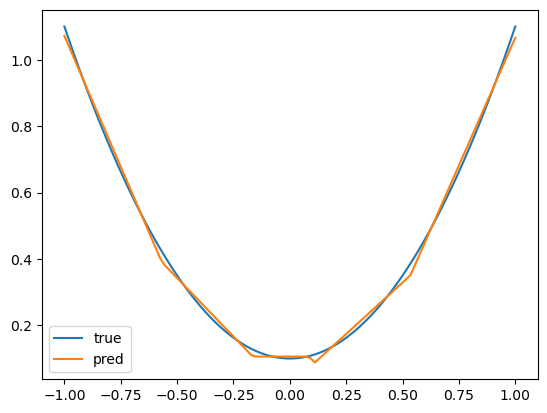

In [7]:
net = MLP(key=jr.key(0))
optim = Optim(net)


@jax.jit
def train_step(net, optim, input, target):
    grads = jax.grad(loss_func)(net, input, target)

    # argnums=1 -> return the updated optim state
    @ft.partial(sk.value_and_tree, argnums=1)
    def apply_optim(grads, optim):
        return optim(grads)

    grads, optim = apply_optim(grads, optim)
    net = jax.tree_util.tree_map(lambda p, g: p + g, net, grads)
    return net, optim


for i in range(1, 10_000 + 1):
    net, optim = train_step(net, optim, input, target)
    if i % 1_000 == 0:
        loss = loss_func(net, input, target)
        print(f"Epoch={i:003d}\tLoss: {loss:.3e}")

plt.plot(input, target, label="true")
plt.plot(input, net(input), label="pred")
plt.legend()

### Line search

In this section [backtracking line search](https://en.wikipedia.org/wiki/Backtracking_line_search) is implemented. The line search is used to find the step size that satisfies the strong [Wolfe conditions](https://en.wikipedia.org/wiki/Wolfe_conditions). for more check [N&W Ch3](https://www.math.uci.edu/~qnie/Publications/NumericalOptimization.pdf). The method is written in a stateful manner, i.e. it modifies the state of the optimizer inplace, However it is executed in a functional manner using `at` method to comply with `jax` transformations.

In [8]:
import jax
import sepes as sk
import jax.numpy as jnp
from typing import Callable
import jax.tree_util as jtu
import functools as ft

# transform numpy function that work on array to
# work on pytree of arrays. additionally if the rhs is a scalar it will
# be broadcasted to the pytree
tree_mul = sk.bcmap(jnp.multiply)
tree_add = sk.bcmap(jnp.add)
tree_neg = sk.bcmap(jnp.negative)
tree_vdot = sk.bcmap(ft.partial(jnp.vdot, precision=jax.lax.Precision.HIGHEST))


def mask_field(**kwargs):
    return sk.field(
        # un mask when the value is accessed
        on_getattr=[lambda x: sk.tree_unmask(x, cond=lambda node: True)],
        # mask when the value is set
        on_setattr=[lambda x: sk.tree_mask(x, cond=lambda node: True)],
        **kwargs,
    )


class BackTrackLS(sk.TreeClass):
    """Backtracking line search with strong Wolfe conditions.

    Args:
        func: the function to be optimized with reskect to the loss function.
            accepts single pytree argument. for multiple arguments use
            `functools.partial` to fix the other arguments.
        maxiter: the maximum number of iterations.
        tol: the tolerance for the stopping criterion.
        c1: the sufficient decrease parameter for the Armijo condition. Must
            statisfy 0<c1<c2<1.
        c2: the curvature condition parameter for the Wolfe condition. Must
            statisfy 0<c1<c2<1.
        step_size: the initial step size.
        decay: the decay rate for the step size.

    Reference:
        - Nocedal and Wright, Numerical Optimization, chapter 3.
        - https://www.math.uci.edu/~qnie/Publications/NumericalOptimization.pdf
    """

    # make func pass through jax transformations
    # without jax complaining about the function not being jax-type
    # see common-recipes->fields for more details
    func: Callable = mask_field()

    def __init__(
        self,
        *,
        func: Callable[..., jax.Array],
        maxiter: int = 100,
        tol: float = 0.0,
        c1: float = 1e-4,
        c2: float = 0.9,
        step_size: float = 1.0,
        decay: float = 0.5,
    ):
        self.func = func
        self.maxiter = maxiter
        self.tol = tol
        # wolfe conditions
        self.c1 = c1  # armijo condition constant
        self.c2 = c2  # curvature condition constant
        self.step_size = step_size
        self.decay = decay

        # conditions numerics
        self.wolfe1 = jnp.inf
        self.wolfe2 = jnp.inf
        self.error = jnp.inf

        # status
        self.tol_reached = False
        self.max_iter_reached = False
        self.fail = False
        self.iter_count = 0

    def step(self, xk0, fk0: jax.Array, dfk0):
        """Compute the next iterate of the line search.

        Args:
            xk0: the initial parameters. accepts pytree.
            fk0: the initial function value.
            dfk0: the initial gradient. accepts pytree same structure as xk0.

        Returns:
            xk1: the next iterate. xk1 = xk0 + αpk
            fk1: the next function value. f(xk0 + αpk)
            dfk1: the next gradient. ∇f(xk0 + αpk)
        """
        # NOTE: calling this method will raise `AttributeError` because
        # its mutating the state (e.g. self.something=something)
        # it will only work if used with `.at` that executes it functionally

        self.step_size = jnp.minimum(1.0, self.step_size)
        # for simplicity we will use the negative gradient as the descent direction
        pk = tree_neg(dfk0)
        # <∇f(xk), pk> but with pytrees
        dfkTpk0 = sum(jtu.tree_leaves(tree_vdot(dfk0, pk)))
        # xk+1 = xk + αpk
        xk1 = tree_add(xk0, tree_mul(pk, self.step_size))
        # f(xk+1), ∇f(xk+1)
        fk1, dfk1 = jax.value_and_grad(self.func)(xk1)
        # <∇f(xk+1), pk> but with pytrees
        dfkTp1 = sum(jtu.tree_leaves(tree_vdot(dfk1, pk)))

        # armijo condition
        # f(xk+1) ≤ f(xk) + c1α∇f(xk)⊤pk
        self.wolfe1 = fk1 - (fk0 + self.c1 * self.step_size * dfkTpk0)

        # curvature condition
        # |∇f(xk+1)⊤pk| ≤ c2|∇f(xk)⊤pk|
        self.wolfe2 = abs(dfkTp1) - self.c2 * abs(dfkTpk0)
        self.error = jnp.maximum(self.wolfe1, self.wolfe2)
        self.error = jnp.maximum(self.error, 0.0)
        self.iter_count += 1

        # check status
        self.tol_reached = self.error <= self.tol
        self.max_iter_reached = self.iter_count >= self.maxiter
        self.fail = self.fail | (self.max_iter_reached & ~self.tol_reached)
        self.step_size = jnp.where(
            self.fail | self.tol_reached,
            self.step_size,
            self.step_size * self.decay,
        )
        return xk1, fk1, dfk1

    @staticmethod
    def cond_func(state) -> bool:
        *_, ls = state
        return ~(ls.fail | ls.tol_reached | ls.max_iter_reached)

    @staticmethod
    def body_func(state):
        (xk0, fk0, dfk0), _, ls = state
        # NOTE: calling this method will raise `AttributeError` because
        # its mutating the state (e.g. self.something=something)
        # it will only work if used with `value_and_tree` that executes it functionally
        (xk1, fk1, dfk1), ls = sk.value_and_tree(lambda ls: ls.step(xk0, fk0, dfk0))(ls)
        return (xk0, fk0, dfk0), (xk1, fk1, dfk1), ls

In [9]:
ls = BackTrackLS(
    func=ft.partial(loss_func, input=input, target=target),
    maxiter=100,
    tol=1e-4,
    c1=1e-4,
    c2=0.9,
    step_size=1.0,
    decay=0.9,
)

# example usage
# pass the initial parameters, function value and gradient
fk0, dfk0 = jax.value_and_grad(loss_func)(net, input, target)
init = (net, fk0, dfk0)
state = init, init, ls
state = jax.lax.while_loop(ls.cond_func, ls.body_func, state)
_, (xk1, fk1, dfk1), ls = state